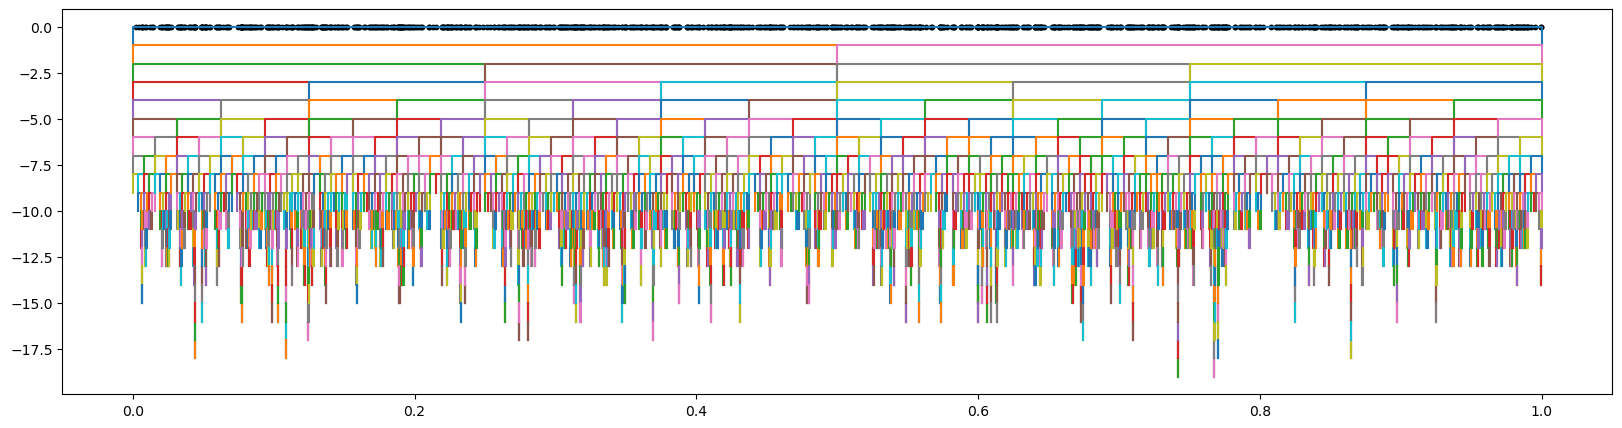

In [2]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from trees import get_1d_tree, get_data_1d, plot_1d_tree, is_far, get_real_features
from trees import flatten_around_point, get_features, plot_1d_tree, data_plotter
from trees import potential_from_features, potential_from_points

# Example usage
key = jax.random.PRNGKey(0)
N = 1000
max_points = 1
center_x, width = 0.5, 1.0

i = np.arange(N)
x = jax.random.uniform(key, (N,), minval=center_x-width/2, maxval=center_x+width/2)
tree_1d = get_1d_tree(i, x, center_x, width, max_points=max_points, data_func=get_data_1d)

plt.figure(figsize=(20, 5))
plot_1d_tree(tree_1d, depth=0, data_plotter=None)
plt.scatter(x, np.zeros_like(x), color='black', s=10)


(-0.05, 1.05, -2.1, 0.1)

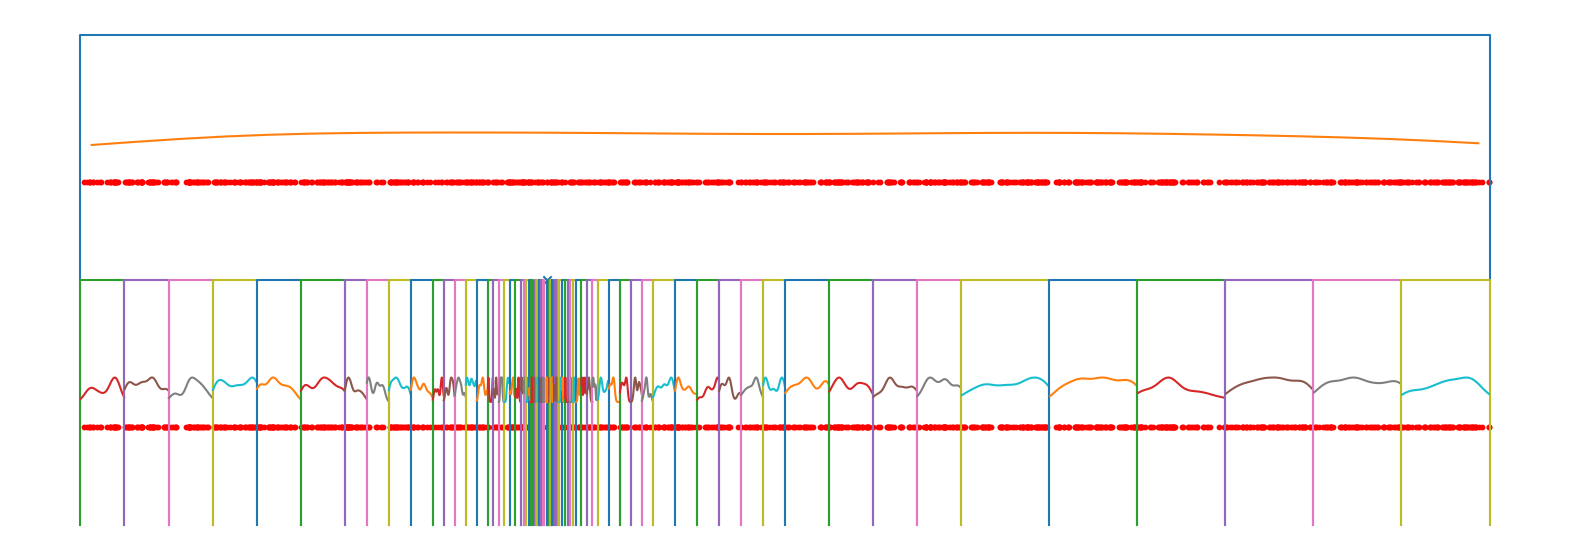

In [2]:
ratio = 0.2
x0 = x[10]#0.2
new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
new_leavy_tree_1d = {"children": new_leaves_1d, "data": tree_1d["data"]}
x0_features = get_features(new_leaves_1d)

plt.figure(figsize=(20, 7))
plot_1d_tree(new_leavy_tree_1d, data_plotter=data_plotter)
plt.scatter([x0], [-1], marker='x')
plt.axis("off")

In [3]:

val = potential_from_points(x0, x)
fmm_val = potential_from_features(x0, x0_features)
print(f"True value: {val}, FMM value: {fmm_val}, Rel. Error: {jnp.abs(val - fmm_val)/jnp.abs(val)}")

training_data = []
data_error = []
for x0 in x:
    new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
    new_leaves_1d = [leaf for leaf in new_leaves_1d if is_far(leaf, x0, ratio)]
    x0_features = get_features(new_leaves_1d)
    x0_features = x0_features.at[:,-2].set(x0_features[:,-2] - x0)
    
    val = potential_from_points(x0, x) / len(x)
    fmm_val = potential_from_features(0., x0_features) / len(x)
    error = jnp.abs(val - fmm_val)/jnp.abs(val)
    print(f"True value: {val:.2f}, FMM value: {fmm_val:.2f}, Rel. Error: {error:.2e} ===========", end='\r')
    data_error.append(error)
    training_data.append((x0_features, val))   

True value: 23375.96473693622, FMM value: 23379.665749360647, Rel. Error: 0.00015832554788971793


In [4]:
from flax import linen as nn
import jax
import jax.numpy as jnp

class MultiHeadSelfAttention(nn.Module):
    embed_dim: int
    num_heads: int

    def setup(self):
        assert self.embed_dim % self.num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = self.embed_dim // self.num_heads
        self.qkv_proj = nn.Dense(self.embed_dim * 3)  # For Query, Key, Value
        self.out_proj = nn.Dense(self.embed_dim)

    def __call__(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape 
        assert embed_dim == self.embed_dim, "Input embedding dimension does not match module embedding dimension."
        
        qkv = self.qkv_proj(x)  # Shape: (batch_size, seq_len, embed_dim * 3)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)  # Each: (batch_size, seq_len, num_heads, head_dim)
        q, k, v = q.squeeze(2), k.squeeze(2), v.squeeze(2)

        # Compute attention weights
        attn_weights = jnp.einsum("bqhd,bkhd->bhqk", q, k) / jnp.sqrt(self.head_dim)
        if mask is not None:
            # Apply mask: set weights to -inf where mask is 0
            attn_weights = jnp.where(mask[:, None, None, :], attn_weights, -1e9)
        attn_weights = jax.nn.softmax(attn_weights, axis=-1)

        # Compute attention output
        attn_output = jnp.einsum("bhqk,bkhd->bqhd", attn_weights, v)
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        return self.out_proj(attn_output)

class TransformerEncoderLayer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    #dropout_rate: float

    def setup(self):
        self.attention = MultiHeadSelfAttention(self.embed_dim, self.num_heads)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.feed_forward = nn.Sequential([
            nn.Dense(self.ff_hidden_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
        ])
        #self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, mask=None, train: bool = True):
        # Multi-head self-attention
        attn_out = self.attention(x, mask)
        x = self.norm1(x + attn_out)#self.dropout(attn_out, deterministic=not train))
        # Feed-forward network
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out)#self.dropout(ff_out, deterministic=not train))
        return x

class Transformer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    num_layers: int
    #dropout_rate: float

    def setup(self):
        self.layers = [
            TransformerEncoderLayer(self.embed_dim, self.num_heads, self.ff_hidden_dim)#, self.dropout_rate)
            for _ in range(self.num_layers)
        ]
        self.final_norm = nn.LayerNorm()
        self.output_layer = nn.Dense(1)  # Produces a single scalar output

    def __call__(self, x, mask, train: bool = True):
        # Apply each Transformer Encoder layer
        for layer in self.layers:
            x = layer(x, mask, train=train)
        x = self.final_norm(x)
        # Global average pooling to make the output independent of sequence length
        x = jnp.sum(x * mask[:, :, None], axis=1) / jnp.sum(mask, axis=1, keepdims=True)
        # Final projection to a single output
        x = self.output_layer(x)
        return x

# Example usage

def make_batches(key, *data, batch_size=16, shuffle=True):
    num_batches = len(data[0]) // batch_size
    if shuffle:
        perm = jax.random.permutation(key, len(data[0]))
        data = [x[perm] for x in data]
    return [tuple(d[i*batch_size:(i+1)*batch_size] for d in data) for i in range(num_batches)]
    
    
def pad_data(data):
    max_len = max(len(x) for x, _ in data)
    padded_x = jnp.stack([jnp.pad(x, ((0, max_len - len(x)), (0,0))) for x, _ in data])
    padded_y = jnp.stack([y for _, y in data])
    return padded_x, padded_y

def create_padding_mask(seq, pad_token=0):
    return (seq != pad_token).astype(jnp.float32)

#help(jnp.pad)
#print(training_data[0][0].shape)
training_data_real = [(get_real_features(x),y) for (x,y) in training_data]
x_train_pad, y_train_pad = pad_data(training_data_real)
x_train_pad = x_train_pad.astype(jnp.float64)
mask_train_pad = create_padding_mask(jnp.linalg.norm(x_train_pad, axis=2))

In [ ]:
from flax.training import train_state
import optax
import jax
import jax.numpy as jnp
import time

compute_loss = lambda params, func,  x, y, mask: jnp.mean((func(params, x, mask) - y)**2/y**2)

@jax.jit
def train_step(state, x, y, mask):
    """
    Performs a single optimization step.
    Args:
        state: A TrainState object containing the optimizer state and model parameters.
        batch: A tuple (inputs, targets) for this batch.
        mask: Padding mask for the input sequences.
    Returns:
        Updated TrainState and loss value.
    """
    
    def loss_fn(params):
        return compute_loss(params, state.apply_fn, x, y, mask)

    # Compute gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    # Apply gradients
    state = state.apply_gradients(grads=grads)
    return state, loss


# Initialize the optimizer and training state
def create_train_state(rng, model, input_shape, mask_shape, learning_rate):
    """
    Creates the training state, including initialized model parameters and the optimizer.
    Args:
        model: The Transformer model.
        rng: Random number generator.
        input_shape: Shape of the input tensor.
        mask_shape: Shape of the mask tensor.
        learning_rate: Learning rate for the optimizer.
    Returns:
        A TrainState object.
    """
    rng, subrng = jax.random.split(rng)
    
    dummy_inputs = jax.random.normal(rng, input_shape)
    dummy_mask = jnp.ones(mask_shape)
    params = model.init(subrng, dummy_inputs, dummy_mask)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Example training loop
def train_model(rng, model, x_train, y_train, mask_train, batch_size, num_epochs, learning_rate):
    """
    Trains the Transformer model.
    Args:
        model: The Transformer model.
        train_data: A dataset of (inputs, targets) pairs.
        train_masks: A dataset of masks corresponding to the inputs.
        num_epochs: Number of epochs to train for.
        learning_rate: Learning rate for the optimizer.
        rng: Random number generator.
    Returns:
        Trained model parameters.
    """
    _, seq_len, embed_dim = x_train.shape  # (batch_size, seq_len, embed_dim)
    rng, subrng = jax.random.split(rng)
    state = create_train_state(subrng, model, (batch_size, seq_len, embed_dim), (batch_size, seq_len,), learning_rate)

    avg_losses = []
    max_losses = []
    min_losses = []
    
    t = time.time()
    for epoch in range(num_epochs):
        rng, subrng = jax.random.split(rng)
        batches = make_batches(subrng, x_train, y_train, mask_train, batch_size=batch_size)
        epoch_losses = []
        for (x, y, mask) in batches:
            state, loss = train_step(state, x, y, mask)
            epoch_losses.append(loss)
        
        epoch_losses = jnp.array(epoch_losses)
        avg_losses.append(jnp.mean(epoch_losses))
        max_losses.append(jnp.max(epoch_losses))
        min_losses.append(jnp.min(epoch_losses))
        t_left = (time.time() - t) * (num_epochs-epoch)/(epoch+1)# in minutes
        t_h = jnp.floor(t_left/3600)
        t_m = jnp.floor((t_left - t_h*3600)/60)
        t_s = t_left - t_m*60 - t_h*3600
        print(f"Epoch {epoch}/{num_epochs}, {t_h:.0f}h{t_m:.0f}m{t_s:.0f}s left, Avg. Loss: {avg_losses[-1]:.2e}, Max Loss: {max_losses[-1]:.2e}, Min Loss: {min_losses[-1]:.2e}", end='\r')

    return state.params, avg_losses, max_losses, min_losses


# Example usage
num_heads = 1
ff_hidden_dim = 128
num_layers = 3
batch_size = 16

key = jax.random.PRNGKey(0)
num_data, seq_len, embed_dim = x_train_pad.shape
model = Transformer(embed_dim, num_heads, ff_hidden_dim, num_layers)#, dropout_rate)

params, avg_losses, max_losses, min_losses  = train_model(key, model, x_train_pad, y_train_pad, mask_train_pad, batch_size, 5000, 1e-3)

In [3]:
import pickle


# Load
with open('model.pickle', 'rb') as f:
    params = pickle.load(f)
    
# Load losses
with open('losses.pickle', 'rb') as f:
    avg_losses, max_losses, min_losses = pickle.load(f)
    
# Load data
with open('data.pickle', 'rb') as f:
    x_train_pad, y_train_pad, mask_train_pad = pickle.load(f)
    
    


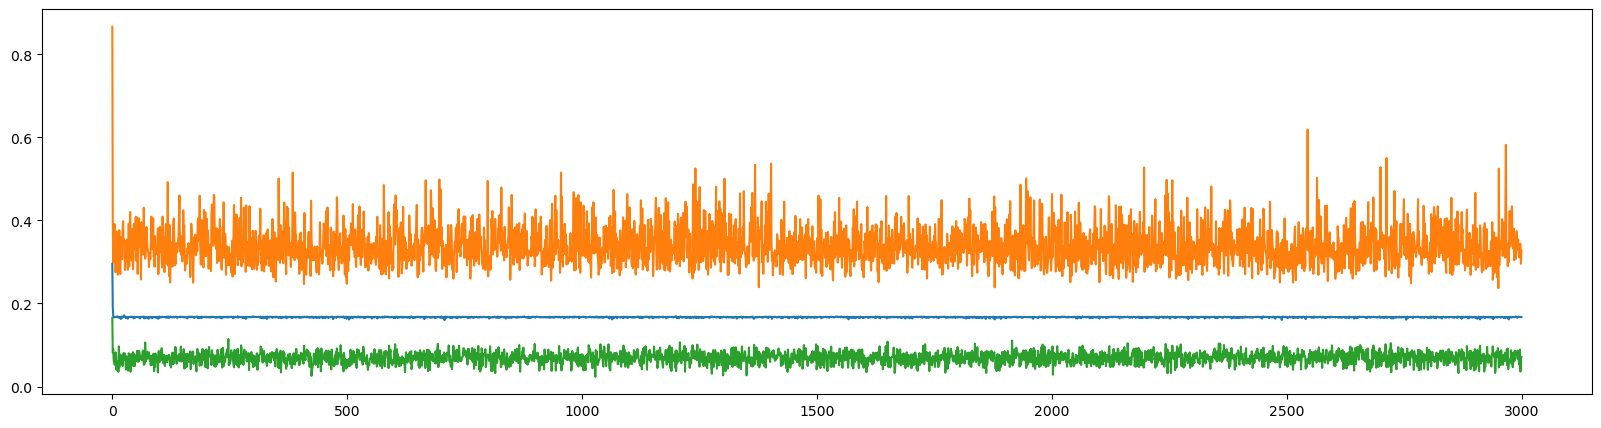

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(avg_losses)
plt.plot(max_losses)
plt.plot(min_losses)